In [10]:
from pathlib import Path
import pickle

import tensorflow as tf
import keras
from keras.datasets import fashion_mnist
from keras.layers import Dense, Dropout, Flatten
from keras.utils import to_categorical
import matplotlib.pyplot as plt 

from keras import layers, models, callbacks
from keras import optimizers, regularizers
from keras import losses, metrics
from keras.utils import plot_model
from keras.utils import serialize_keras_object, to_categorical

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, AutoLocator, FixedLocator
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, roc_auc_score
from sklearn.model_selection import train_test_split

In [3]:
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)

---
# Завантажуємо датасет
---

In [4]:
# Завантаження датасету Fashion MNIST
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# 1. Нормалізація пікселів (0-255 -> 0-1)
x_train, x_test = (x_train / 255.0).astype("float32"), (x_test / 255.0).astype(
    "float32"
)

# 2. Поділ на train/val (10 % для валідації)
x_train, x_val, y_train, y_val = train_test_split(
    x_train, y_train, test_size=0.1, random_state=SEED, stratify=y_train
)


# 3. Функція для графіків
def plot_history(h, title=""):
    plt.plot(h.history["loss"], label="train loss")
    plt.plot(h.history["val_loss"], label="val loss")
    plt.plot(h.history["accuracy"], label="train acc")
    plt.plot(h.history["val_accuracy"], label="val acc")
    plt.title(title)
    plt.xlabel("epoch")
    plt.legend()
    plt.show()

In [5]:
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)
print(x_val.shape, y_val.shape)

(54000, 28, 28) (54000,)
(10000, 28, 28) (10000,)
(6000, 28, 28) (6000,)


In [6]:
# Список назв класів
class_names = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

# Виведення назви класу для першого зображення
index = 0  # Індекс зображення
print(f"Мітка: {y_train[index]}, Назва класу: {class_names[y_train[index]]}")

Мітка: 8, Назва класу: Bag


---
# Візуалізуємо зображення з нашого датасету:
---

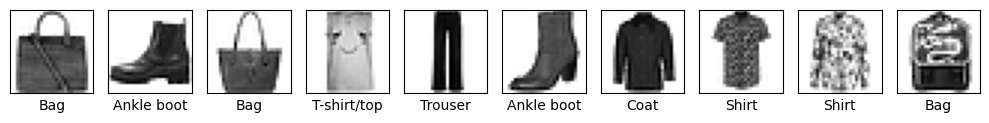

In [7]:
plt.figure(figsize=(10, 10))
# Цикл для відображення перших 10 зображень
for i in range(10):
    plt.subplot(1, 10, i + 1)

    # Видалення осей (ticks) для кращої візуалізації
    plt.xticks([])
    plt.yticks([])

    # Відображення зображення у градаціях сірого (чорно-білий режим)
    plt.imshow(x_train[i], cmap=plt.cm.binary)

    # Додавання підпису з назвою класу під зображенням
    plt.xlabel(class_names[y_train[i]])

# Показ всіх створених графіків
plt.tight_layout()  # Автоматичне регулювання відступів
plt.show()

---
# Частина 1
---

## Створення згортковоі нейромережи

In [ ]:
def make_cnn():
    inputs = keras.Input(
        shape=(28, 28, 1), name="img"
    )

    x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(inputs)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(x)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Conv2D(128, (3, 3), activation="relu", padding="same")(x)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Flatten()(x)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(10, activation="softmax")(x)

    return keras.Model(inputs, outputs, name="cnn_model")

## Тренування

In [11]:
model = make_cnn()
model.summary()

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

cb = [
    callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=6,
        restore_best_weights=True,
    ),
    callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.5,
        patience=3,
        min_lr=1e-5,
        verbose=1,
    ),
]

history = model.fit(
    x_train,
    y_train,
    validation_data=(x_val, y_val),
    epochs=60,
    batch_size=128,
    callbacks=cb,
    verbose=2,
)

test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
print(f"Тестова точність: {test_acc:.3%}")

Model: "cnn_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ img (InputLayer)                │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 241,546 (943.54 KB)

 Trainable params: 241,546 (943.54 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/60
422/422 - 10s - 25ms/step - accuracy: 0.7788 - loss: 0.6093 - val_accuracy: 0.8687 - val_loss: 0.3660 - learning_rate: 0.0010
Epoch 2/60
422/422 - 10s - 23ms/step - accuracy: 0.8697 - loss: 0.3602 - val_accuracy: 0.8880 - val_loss: 0.3091 - learning_rate: 0.0010
Epoch 3/60
422/422 - 9s - 22ms/step - accuracy: 0.8890 - loss: 0.3040 - val_accuracy: 0.9002 - val_loss: 0.2717 - learning_rate: 0.0010
Epoch 4/60
422/422 - 10s - 23ms/step - accuracy: 0.9021 - loss: 0.2688 - val_accuracy: 0.9098 - val_loss: 0.2503 - learning_rate: 0.0010
Epoch 5/60
422/422 - 10s - 23ms/step - accuracy: 0.9090 - loss: 0.2450 - val_accuracy: 0.9147 - val_loss: 0.2303 - learning_rate: 0.0010
Epoch 6/60
422/422 - 10s - 24ms/step - accuracy: 0.9179 - loss: 0.2245 - val_accuracy: 0.9135 - val_loss: 0.2325 - learning_rate: 0.0010
Epoch 7/60
422/422 - 10s - 23ms/step - accuracy: 0.9241 - loss: 0.2071 - val_accuracy: 0.9215 - val_loss: 0.2143 - learning_rate: 0.0010
Epoch 8/60
422/422 - 10s - 23ms/step - acc

### Результати покращились, але спробуємо ускладнити модель

In [25]:
def make_advanced_cnn(input_shape=(28, 28, 1), num_classes=10):
    inputs = keras.Input(shape=input_shape, name="img")
    # Data augmentation
    x = layers.RandomFlip("horizontal")(inputs)
    x = layers.RandomRotation(0.05)(x)

    x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(x)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(x)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Conv2D(128, (3, 3), activation="relu", padding="same")(x)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Flatten()(x)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dropout(0.2)(x)

    x = layers.Dense(512, activation="relu")(x)
    x = layers.Dropout(0.2)(x)

    # Output
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    return models.Model(inputs, outputs, name="advanced_cnn")


model = make_advanced_cnn()
model.compile(
    optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)
cb = [
    callbacks.EarlyStopping(
        patience=6, restore_best_weights=True, monitor="val_accuracy"
    ),
    callbacks.ReduceLROnPlateau(
        patience=3, factor=0.5, min_lr=1e-5, monitor="val_loss", verbose=1
    ),
]

## Навчання новоі моделі

In [26]:
history = model.fit(
    x_train,
    y_train,
    validation_data=(x_val, y_val),
    epochs=60,
    batch_size=128,
    callbacks=cb,
    verbose=2,
)

Epoch 1/60
422/422 - 12s - 28ms/step - accuracy: 0.7279 - loss: 0.7191 - val_accuracy: 0.8342 - val_loss: 0.4350 - learning_rate: 0.0010
Epoch 2/60
422/422 - 11s - 26ms/step - accuracy: 0.8326 - loss: 0.4516 - val_accuracy: 0.8715 - val_loss: 0.3397 - learning_rate: 0.0010
Epoch 3/60
422/422 - 11s - 25ms/step - accuracy: 0.8563 - loss: 0.3894 - val_accuracy: 0.8835 - val_loss: 0.3150 - learning_rate: 0.0010
Epoch 4/60
422/422 - 11s - 25ms/step - accuracy: 0.8671 - loss: 0.3572 - val_accuracy: 0.8890 - val_loss: 0.2982 - learning_rate: 0.0010
Epoch 5/60
422/422 - 11s - 27ms/step - accuracy: 0.8775 - loss: 0.3291 - val_accuracy: 0.8927 - val_loss: 0.2819 - learning_rate: 0.0010
Epoch 6/60
422/422 - 11s - 26ms/step - accuracy: 0.8844 - loss: 0.3124 - val_accuracy: 0.8983 - val_loss: 0.2759 - learning_rate: 0.0010
Epoch 7/60
422/422 - 11s - 26ms/step - accuracy: 0.8887 - loss: 0.2961 - val_accuracy: 0.9065 - val_loss: 0.2611 - learning_rate: 0.0010
Epoch 8/60
422/422 - 11s - 26ms/step - ac

Тестова точність: 91.590%


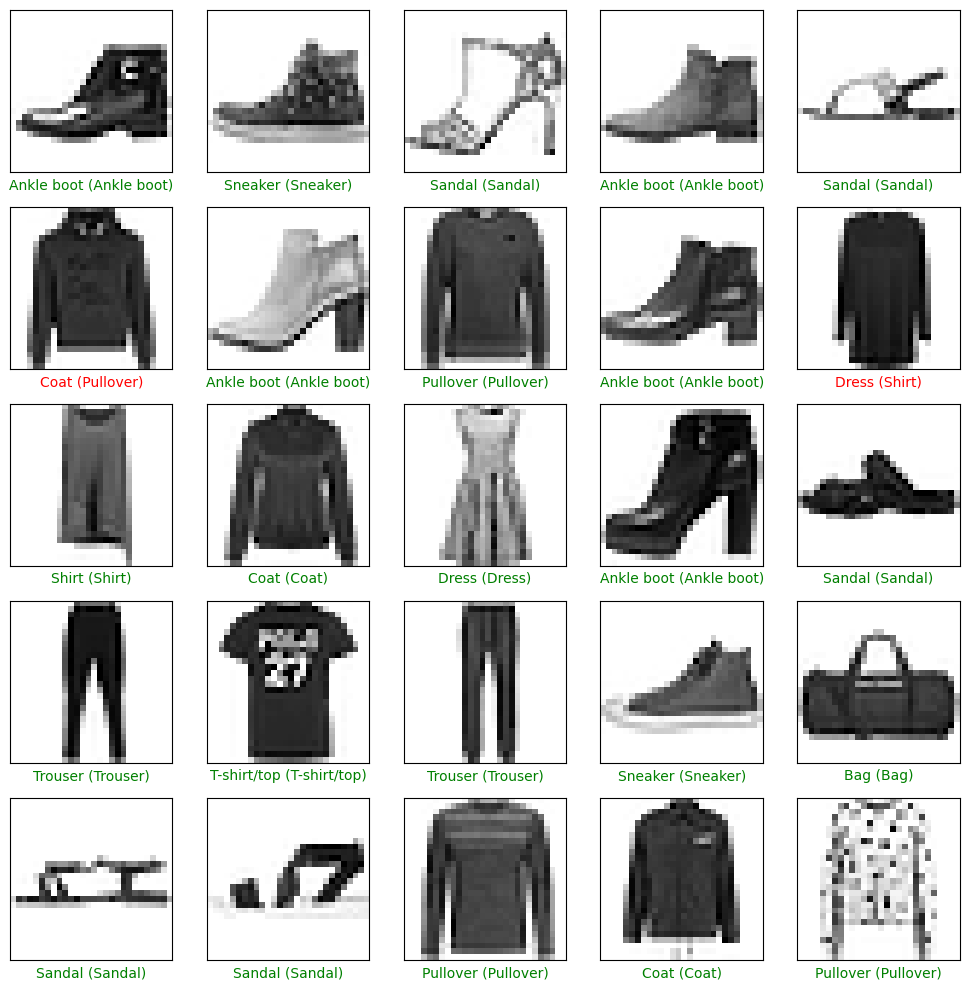

In [27]:
#  Передбачення
y_pred = model.predict(x_test, verbose=0)
#  Виведення точності на тестовому наборі
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
print(f"Тестова точність: {test_acc:.3%}")
#  Візуалізуємо 25 випадкових зображень і передбачення
figure = plt.figure(figsize=(10, 10))
indices = np.random.choice(len(x_test), size=25, replace=False)

for i, idx in enumerate(indices):
    ax = figure.add_subplot(5, 5, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(x_test[idx]), cmap=plt.cm.binary)

    pred_idx = np.argmax(y_pred[idx])
    true_idx = y_test[idx]

    ax.set_xlabel(
        f"{class_names[pred_idx]} ({class_names[true_idx]})",
        color=("green" if pred_idx == true_idx else "red"),
    )

plt.tight_layout()
plt.show()

---
# Висновкі
---

1. Базова CNN показала найкращі результати:
Вона проста, але добре узагальнює.

2. Advanced CNN має більше параметрів, але не дала приросту:
Можливо, data augmentation не дало виграшу, бо одяг на зображеннях досить простий.

Також, Dropout 0.2 + 0.2 — можливо, забагато для таких шарів.

3. MLP досяг хороших результатів, але поступається CNN:
Це очікувано: MLP не вловлює просторові зв’язки, як CNN.

---
# Частина 2 - VGG16
---

In [ ]:
import numpy as np
from keras.applications import VGG16
from keras import layers
from keras.applications.vgg16 import preprocess_input
from skimage.color import gray2rgb
from keras.utils import array_to_img, img_to_array
from PIL import Image

# Завантаження та підготовка даних
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()


# Змінюємо розмір зображень на 48х48 (розмір вхідного зображення для VGG16)
def resize_grayscale_images(data, target_size=(48, 48)):
    """
    Змінює розмір grayscale-зображень до target_size і нормалізує (опціонально).

    Parameters:
        data (np.ndarray): Масив зображень (N, H, W)
        target_size (tuple): Розмір зображення (ширина, висота)
        normalize (bool): Чи нормалізувати значення [0, 255] → [0, 1]

    Returns:
        np.ndarray: Масив resized зображень у форматі (N, H, W, 1)
    """
    resized = []
    for img in data:
        # Розширюємо до (H, W, 1)
        img = np.expand_dims(img, axis=-1)
        pil_img = array_to_img(img)
        resized_img = pil_img.resize(target_size, Image.BILINEAR)
        arr = img_to_array(resized_img) / 255.0
        resized.append(arr)
    return np.array(resized)

x_train_resized = resize_grayscale_images(x_train, target_size=(48, 48))
x_test_resized = resize_grayscale_images(x_test, target_size=(48, 48))

In [54]:
# Розширення до 3 каналів (grayscale → RGB)
x_train_rgb = np.array([gray2rgb(img).squeeze() for img in x_train_resized])
x_test_rgb = np.array([gray2rgb(img).squeeze() for img in x_test_resized])

In [55]:
x_train_rgb.shape, x_test_rgb.shape

((60000, 48, 48, 3), (10000, 48, 48, 3))

In [ ]:
# Зробимо tf.data.Dataset
def preprocess(image, label):
    image = tf.cast(image, tf.float32) / 255.0  # нормалізація
    return image, label

y_train_cat = to_categorical(y_train, num_classes=10)
y_test_cat = to_categorical(y_test, num_classes=10)

# ❗ Створення tf.data.Dataset
batch_size = 64

train_ds = tf.data.Dataset.from_tensor_slices((x_train_rgb, y_train_cat))
train_ds = (
    train_ds.map(preprocess).shuffle(10000).batch(batch_size).prefetch(tf.data.AUTOTUNE)
)

test_ds = tf.data.Dataset.from_tensor_slices((x_test_rgb, y_test_cat))
test_ds = test_ds.map(preprocess).batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [58]:
train_ds.element_spec, test_ds.element_spec

((TensorSpec(shape=(None, 48, 48, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None,), dtype=tf.uint8, name=None)),
 (TensorSpec(shape=(None, 48, 48, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None,), dtype=tf.uint8, name=None)))

## Зробимо базову модель

In [49]:
base_model = VGG16(weights="imagenet", include_top=False, input_shape=(48, 48, 3))


In [50]:
base_model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 48, 48, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 48, 48, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 48, 48, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 6, 6, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 3, 3, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 3, 3, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 3, 3, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 1, 1, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Тренуємо модель
model.fit(train_ds, validation_data=test_ds, epochs=10)